In [2]:
import numpy as np
import pandas as pd

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.
/Users/atakanokan/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
np.random.seed(7)

In [5]:
folder_dir = '../data/'
data_path = "data_clean.csv"
data = pd.read_csv(filepath_or_buffer= folder_dir + data_path, header=0)
data=data.drop('Unnamed: 0',axis=1)

In [6]:
data.shape

(3700449, 37)

In [7]:
data.columns

Index(['date', 'umpcall', 'outcome', 'start_speed', 'pfx_x', 'pfx_z', 'px',
       'pz', 'break_y', 'break_angle', 'break_length', 'pitch_type',
       'spin_dir', 'nasty', 'pitch_count', 'descr', 'y', 'year', 'count_b_p',
       'strikes', 'balls', 'pitcher', 'pitch_type.1', 'rolling_start_speed',
       'long_rolling_start_speed', 'zone_1', 'zone_2', 'zone_3', 'zone_4',
       'zone_5', 'zone_6', 'zone_7', 'zone_8', 'zone_9', 'zone_11', 'zone_12',
       'zone_13'],
      dtype='object')

In [8]:
data['dist']=np.sqrt(data['px']**2+data['pz']**2)
data['speed_diff']=data['rolling_start_speed']-data['long_rolling_start_speed']

In [9]:
pitch_types=pd.get_dummies(data['pitch_type'],prefix='pitch_type')
data=pd.concat([data,pitch_types],axis=1)
pitch_types=0

In [10]:
# model_feats=['px','pz','pfx_x','pfx_z','start_speed',
#              'spin_dir','pitch_count','balls','strikes','date',
#              'y','rolling_start_speed']

model_feats=['px','pz','pfx_x','pfx_z','start_speed','spin_dir',
             'pitch_count','balls','strikes','date',
             'y','speed_diff','dist','pitch_type_CH', 
             'pitch_type_CU','pitch_type_FC', 'pitch_type_FF', 
             'pitch_type_FS', 'pitch_type_FT', 'pitch_type_KC', 
             'pitch_type_SI', 'pitch_type_SL']

# model_feats=['px','pz','pfx_x','pfx_z','y','strikes','date']

In [11]:
import datetime

data["date"] = pd.to_datetime(data["date"])

start = data["date"].searchsorted(datetime.datetime(2012, 1, 1))[0]
#start
end = data["date"].searchsorted(datetime.datetime(2016, 1, 1))[0] - 1
#end

X_train = data[model_feats].loc[start:end]
y_train=X_train['y']
X_train=X_train.drop(['y','date'],axis=1)

X_test=data[model_feats][end:]
y_test=X_test['y']
X_test=X_test.drop(['y','date'],axis=1)
data=0

# Fully Connected Neural Net

In [12]:
X_train.shape

(3221706, 20)

In [13]:
X_train.shape[1]

20

In [14]:
len(model_feats)

22

In [15]:
input_dim = X_train.shape[1]

In [16]:
from keras.layers import PReLU

In [17]:
model = Sequential()
model.add(Dense(30, input_dim=input_dim, activation='relu'))
#model.add(Dropout(rate = 0.1, noise_shape=None, seed=None))
model.add(Dense(20, activation='relu'))
#model.add(Dropout(rate = 0.1, noise_shape=None, seed=None))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [18]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [19]:
model.fit(x = X_train, 
          y = y_train, 
          epochs=10, 
          batch_size=50)

Epoch 1/10
3221706/3221706 [==============================] - 80s 25us/step - loss: 0.5149 - acc: 0.7503
Epoch 2/10
3221706/3221706 [==============================] - 88s 27us/step - loss: 0.4811 - acc: 0.7794
Epoch 3/10
3221706/3221706 [==============================] - 88s 27us/step - loss: 0.4784 - acc: 0.7810
Epoch 4/10
2447850/3221706 [=====================>........] - ETA: 20s - loss: 0.4772 - acc: 0.7815

KeyboardInterrupt: 

In [20]:
scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

478744/478744 [==============================] - 7s 16us/step

acc: 77.56%


In [21]:
from sklearn.metrics import log_loss

In [22]:
X_test.shape

(478744, 20)

In [23]:
probs=model.predict_proba(X_test)

In [24]:
probs.shape

(478744, 1)

In [29]:
probs

array([[ 0.775617  ],
       [ 0.76744443],
       [ 0.74518639],
       ..., 
       [ 0.77617234],
       [ 0.25921917],
       [ 0.775617  ]], dtype=float32)

In [25]:
loglog_loss=log_loss(y_test,probs)
loglog_loss

0.48554904799604848

In [32]:
preds = (model.predict_proba(x=X_test) > 0.5).astype(int)
preds

array([[1],
       [1],
       [1],
       ..., 
       [1],
       [0],
       [1]])

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

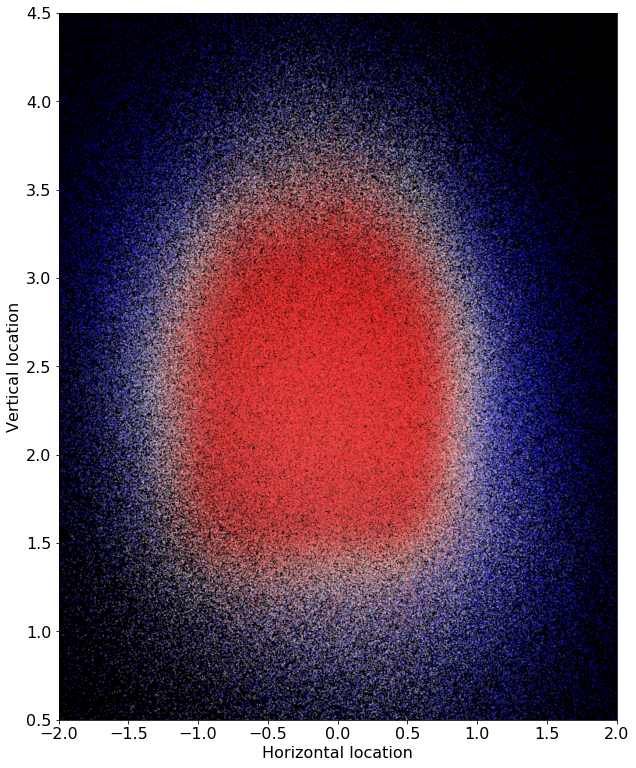

In [33]:
plt.rcParams['axes.facecolor'] = "black"
plt.figure(figsize=(10,13))
plt.xlim(-2.0,2.0)
plt.ylim(0.5,4.5)
plt.scatter(X_test['px'],X_test['pz'],s=0.5, c=probs, 
            alpha=0.2, cmap='bwr');
plt.xlabel('Horizontal location',fontsize=16)
plt.ylabel('Vertical location',fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
#plt.legend(('Bad Pitch', 'Good Pitch'), loc='best', fontsize=16)
plt.savefig('predictions_class_NN.jpg', dpi = 100)

In [ ]:
if_wrong_predictions = np.array(preds != y_test).astype(int)
plt.rcParams['axes.facecolor'] = 'white'

plt.figure(figsize=(10,13))
plt.xlim(-2,2)
plt.ylim(0.5,4.5)

plt.scatter(X_test['px'],X_test['pz'],s=.5, c=if_wrong_predictions, alpha=0.3, cmap='bwr');

plt.xlabel('Horizontal location',fontsize=18)
plt.ylabel('Vertical location',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)

plt.savefig('errors_NN.jpg', format='jpg', dpi=100)

# Neural Net 2

In [58]:
model2 = Sequential()
model2.add(Dense(40, input_dim=input_dim, activation='relu'))
#model.add(Dropout(rate = 0.1, noise_shape=None, seed=None))
model2.add(Dense(40, activation='relu'))
#model.add(Dropout(rate = 0.1, noise_shape=None, seed=None))
model2.add(Dense(20, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

In [59]:
model2.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [60]:
model2.fit(x = X_train, 
          y = y_train, 
          epochs=50, 
          batch_size=50)

Epoch 1/50
3221706/3221706 [==============================] - 94s 29us/step - loss: 0.5262 - acc: 0.7409
Epoch 2/50
3221706/3221706 [==============================] - 94s 29us/step - loss: 0.4782 - acc: 0.7811
Epoch 3/50
3221706/3221706 [==============================] - 94s 29us/step - loss: 0.4757 - acc: 0.7826
Epoch 4/50
3221706/3221706 [==============================] - 94s 29us/step - loss: 0.4746 - acc: 0.7834
Epoch 5/50
3221706/3221706 [==============================] - 92s 28us/step - loss: 0.4739 - acc: 0.7837
Epoch 6/50
3221706/3221706 [==============================] - 93s 29us/step - loss: 0.4734 - acc: 0.7841
Epoch 7/50
3221706/3221706 [==============================] - 97s 30us/step - loss: 0.4730 - acc: 0.7845
Epoch 8/50
3221706/3221706 [==============================] - 100s 31us/step - loss: 0.4727 - acc: 0.7845
Epoch 9/50
3221706/3221706 [==============================] - 95s 29us/step - loss: 0.4724 - acc: 0.7848
Epoch 10/50
3221706/3221706 [=========================

In [62]:
scores = model2.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model2.metrics_names[1], scores[1]*100))

478744/478744 [==============================] - 9s 18us/step

acc: 78.43%
